### Цирулев Н.В. М8О-408Б-22
# Лабораторная работа №5 (Проведение исследований с градиентным бустингом)

In [2]:
import re
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import kagglehub

from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    mean_absolute_error, r2_score, root_mean_squared_error
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
TEST_SIZE = 0.2

TUNE_N_CLF = 20000
CV_SPLITS_CLF = 2

CV_SPLITS_REG = 5


def eval_clf(y_true, y_pred, title: str):
    precision = precision_score(y_true, y_pred, pos_label=1, zero_division=0)
    recall = recall_score(y_true, y_pred, pos_label=1, zero_division=0)
    f1 = f1_score(y_true, y_pred, pos_label=1, zero_division=0)

    print(f"\n=== {title} ===")
    print(f"precision: {precision:.6f}")
    print(f"recall:    {recall:.6f}")
    print(f"f1:        {f1:.6f}")

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    ConfusionMatrixDisplay(cm, display_labels=["legitimate(0)", "phishing(1)"]).plot(values_format="d")
    plt.title(title)
    plt.show()

    return {"precision": precision, "recall": recall, "f1": f1}


def eval_reg(y_true, y_pred, title: str):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = root_mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"\n=== {title} ===")
    print(f"MAE:  {mae:.3f}")
    print(f"RMSE: {rmse:.3f}")
    print(f"R2:   {r2:.5f}")

    return {"MAE": mae, "RMSE": rmse, "R2": r2}


def load_from_kagglehub(dataset_id: str) -> pd.DataFrame:
    path = kagglehub.dataset_download(dataset_id)
    root = Path(path)
    csv_path = max(root.rglob("*.csv"), key=lambda p: p.stat().st_size)
    df = pd.read_csv(csv_path)
    df.columns = df.columns.str.strip()
    print("Loaded:", dataset_id)
    print("CSV:", csv_path)
    print("Shape:", df.shape)
    return df


def parse_number(x):
    if pd.isna(x):
        return np.nan
    m = re.search(r"(\d+)", str(x))
    return float(m.group(1)) if m else np.nan


def clean_laptop(df_in: pd.DataFrame) -> pd.DataFrame:
    dfc = df_in.copy()
    dfc.columns = dfc.columns.str.strip()

    for col in ["ram_gb", "ssd", "hdd", "graphic_card_gb", "os_bit", "rating", "processor_gnrtn"]:
        if col in dfc.columns:
            dfc[col] = dfc[col].map(parse_number)

    if "Price" in dfc.columns:
        dfc["Price"] = pd.to_numeric(dfc["Price"], errors="coerce")

    for col in ["Number of Ratings", "Number of Reviews"]:
        if col in dfc.columns:
            dfc[col] = pd.to_numeric(dfc[col], errors="coerce")

    return dfc

### Имплементации алгоритма:

In [3]:
import re
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt

import kagglehub

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from sklearn.compose import TransformedTargetRegressor

from sklearn.metrics import (
    precision_score, recall_score, f1_score,
    confusion_matrix, ConfusionMatrixDisplay,
    mean_absolute_error, r2_score, root_mean_squared_error
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
TEST_SIZE = 0.2

TUNE_N_CLF = 20000
CV_SPLITS_CLF = 2
CV_SPLITS_REG = 5

def _sigmoid(z):
    z = np.clip(z, -50.0, 50.0)
    return 1.0 / (1.0 + np.exp(-z))


class _UniformBinner:
    def __init__(self, max_bins=64):
        self.max_bins = int(max_bins)
        self.mins_ = None
        self.maxs_ = None
        self.denoms_ = None
        self.valid_ = None

    def fit(self, X):
        X = np.asarray(X, dtype=np.float32)
        self.mins_ = np.nanmin(X, axis=0).astype(np.float32)
        self.maxs_ = np.nanmax(X, axis=0).astype(np.float32)
        den = (self.maxs_ - self.mins_).astype(np.float32)
        self.valid_ = np.isfinite(self.mins_) & np.isfinite(self.maxs_) & (den > 0)
        self.denoms_ = np.where(self.valid_, den, 1.0).astype(np.float32)
        return self

    def transform(self, X):
        X = np.asarray(X, dtype=np.float32)
        bins = self.max_bins
        scaled = (X - self.mins_) / self.denoms_
        scaled = np.clip(scaled, 0.0, 1.0)
        idx = np.floor(scaled * bins).astype(np.int32)
        idx = np.clip(idx, 0, bins - 1).astype(np.uint8)
        idx[:, ~self.valid_] = 0
        return idx

    def thr_from_bin(self, j, k):
        return float(self.mins_[j] + ((k + 1) / self.max_bins) * self.denoms_[j])


class _HistNewtonTree:
    def __init__(self, max_depth=3, min_samples_split=2, min_samples_leaf=20, max_features=1.0, max_bins=64, l2=0.0, random_state=42):
        self.max_depth = None if max_depth is None else int(max_depth)
        self.min_samples_split = int(min_samples_split)
        self.min_samples_leaf = int(min_samples_leaf)
        self.max_features = max_features
        self.max_bins = int(max_bins)
        self.l2 = float(l2)
        self.random_state = int(random_state)
        self._rng = np.random.default_rng(self.random_state)

        self.X_ = None
        self.Xb_ = None
        self.g_ = None
        self.h_ = None
        self.binner_ = None

        self.n_features_ = None
        self.root_ = None

    def fit(self, X, Xb, g, h, binner):
        self.X_ = np.asarray(X, dtype=np.float32)
        self.Xb_ = np.asarray(Xb, dtype=np.uint8)
        self.g_ = np.asarray(g, dtype=np.float32)
        self.h_ = np.asarray(h, dtype=np.float32)
        self.binner_ = binner
        self.n_features_ = self.X_.shape[1]
        idxs = np.arange(self.X_.shape[0], dtype=np.int32)
        self.root_ = self._build(idxs, depth=0)
        return self

    def predict(self, X):
        X = np.asarray(X, dtype=np.float32)
        out = np.empty(X.shape[0], dtype=np.float32)
        idxs = np.arange(X.shape[0], dtype=np.int32)
        self._predict_into(self.root_, X, idxs, out)
        return out

    def _predict_into(self, node, X, idxs, out):
        if node["is_leaf"]:
            out[idxs] = node["value"]
            return
        feat = node["feat"]
        thr = node["thr"]
        col = X[idxs, feat]
        left_mask = col <= thr
        if np.any(left_mask):
            self._predict_into(node["left"], X, idxs[left_mask], out)
        if np.any(~left_mask):
            self._predict_into(node["right"], X, idxs[~left_mask], out)

    def _leaf_value(self, idxs):
        G = float(self.g_[idxs].sum())
        H = float(self.h_[idxs].sum())
        return float(-G / (H + self.l2 + 1e-12))

    def _stop(self, idxs, depth):
        n = idxs.size
        if self.max_depth is not None and depth >= self.max_depth:
            return True
        if n < self.min_samples_split:
            return True
        if n < 2 * self.min_samples_leaf:
            return True
        return False

    def _k_features(self):
        p = self.n_features_
        mf = self.max_features
        if mf is None:
            return p
        if isinstance(mf, str):
            if mf == "sqrt":
                return max(1, int(np.sqrt(p)))
            if mf == "log2":
                return max(1, int(np.log2(p)))
            return p
        if isinstance(mf, float):
            if mf <= 0:
                return p
            if mf <= 1.0:
                return max(1, int(np.ceil(p * mf)))
            return min(p, int(mf))
        return min(p, int(mf))

    def _feature_subset(self):
        p = self.n_features_
        k = min(p, self._k_features())
        if k >= p:
            return np.arange(p, dtype=np.int32)
        return self._rng.choice(p, size=k, replace=False).astype(np.int32)

    def _gain(self, GL, HL, GR, HR, G, H):
        l2 = self.l2
        return float((GL * GL) / (HL + l2 + 1e-12) + (GR * GR) / (HR + l2 + 1e-12) - (G * G) / (H + l2 + 1e-12))

    def _best_split(self, idxs):
        n = idxs.size
        g = self.g_[idxs]
        h = self.h_[idxs]
        G = float(g.sum())
        H = float(h.sum())

        best_feat = None
        best_thr = None
        best_gain = 0.0

        feats = self._feature_subset()
        bins = self.max_bins

        for j in feats:
            b = self.Xb_[idxs, j].astype(np.int32)
            cnt = np.bincount(b, minlength=bins).astype(np.float64)
            sumg = np.bincount(b, weights=g, minlength=bins).astype(np.float64)
            sumh = np.bincount(b, weights=h, minlength=bins).astype(np.float64)

            left_cnt = np.cumsum(cnt)
            left_g = np.cumsum(sumg)
            left_h = np.cumsum(sumh)

            right_cnt = n - left_cnt
            right_g = G - left_g
            right_h = H - left_h

            valid = (left_cnt >= self.min_samples_leaf) & (right_cnt >= self.min_samples_leaf)
            if not np.any(valid):
                continue

            gains = np.empty(bins, dtype=np.float64)
            gains[:] = -np.inf
            idx_valid = np.where(valid)[0]
            for k in idx_valid:
                GL = float(left_g[k]); HL = float(left_h[k])
                GR = float(right_g[k]); HR = float(right_h[k])
                gains[k] = self._gain(GL, HL, GR, HR, G, H)

            kbest = int(np.argmax(gains))
            gb = float(gains[kbest])
            if np.isfinite(gb) and gb > best_gain:
                best_gain = gb
                best_feat = int(j)
                best_thr = self.binner_.thr_from_bin(j, kbest)

        return best_feat, best_thr, best_gain

    def _build(self, idxs, depth):
        if self._stop(idxs, depth):
            return {"is_leaf": True, "value": self._leaf_value(idxs)}

        feat, thr, gain = self._best_split(idxs)
        if feat is None or thr is None or gain <= 0.0:
            return {"is_leaf": True, "value": self._leaf_value(idxs)}

        col = self.X_[idxs, feat]
        left_mask = col <= thr
        left_idxs = idxs[left_mask]
        right_idxs = idxs[~left_mask]
        if left_idxs.size < self.min_samples_leaf or right_idxs.size < self.min_samples_leaf:
            return {"is_leaf": True, "value": self._leaf_value(idxs)}

        return {
            "is_leaf": False,
            "feat": int(feat),
            "thr": float(thr),
            "left": self._build(left_idxs, depth + 1),
            "right": self._build(right_idxs, depth + 1),
        }


class HistGradientBoostingClassifierScratch:
    def __init__(self, max_iter=100, learning_rate=0.1, max_depth=3, min_samples_leaf=20, max_features=1.0, l2_regularization=0.0, max_bins=64, random_state=42):
        self.max_iter = int(max_iter)
        self.learning_rate = float(learning_rate)
        self.max_depth = None if max_depth is None else int(max_depth)
        self.min_samples_leaf = int(min_samples_leaf)
        self.max_features = max_features
        self.l2_regularization = float(l2_regularization)
        self.max_bins = int(max_bins)
        self.random_state = int(random_state)
        self._rng = np.random.default_rng(self.random_state)

        self.init_ = 0.0
        self.binner_ = None
        self.trees_ = []

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=np.int32)
        n = X.shape[0]

        p = float(np.clip(y.mean(), 1e-6, 1 - 1e-6))
        self.init_ = float(np.log(p / (1.0 - p)))
        F = np.full(n, self.init_, dtype=np.float32)

        self.binner_ = _UniformBinner(max_bins=self.max_bins).fit(X)
        Xb = self.binner_.transform(X)

        self.trees_ = []
        for m in range(self.max_iter):
            prob = _sigmoid(F)
            g = (prob - y.astype(np.float32)).astype(np.float32)
            h = (prob * (1.0 - prob)).astype(np.float32)

            tree = _HistNewtonTree(
                max_depth=self.max_depth,
                min_samples_split=2,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features,
                max_bins=self.max_bins,
                l2=self.l2_regularization,
                random_state=int(self._rng.integers(0, 2**31 - 1))
            )
            tree.fit(X, Xb, g, h, self.binner_)
            update = tree.predict(X)
            F += self.learning_rate * update
            self.trees_.append(tree)

        return self

    def predict_proba(self, X):
        X = np.asarray(X, dtype=np.float32)
        F = np.full(X.shape[0], self.init_, dtype=np.float32)
        for tree in self.trees_:
            F += self.learning_rate * tree.predict(X)
        p = _sigmoid(F)
        return np.vstack([1.0 - p, p]).T

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(np.int32)


class HistGradientBoostingRegressorScratch:
    def __init__(self, max_iter=200, learning_rate=0.05, max_depth=3, min_samples_leaf=20, max_features=1.0, l2_regularization=0.0, max_bins=64, random_state=42):
        self.max_iter = int(max_iter)
        self.learning_rate = float(learning_rate)
        self.max_depth = None if max_depth is None else int(max_depth)
        self.min_samples_leaf = int(min_samples_leaf)
        self.max_features = max_features
        self.l2_regularization = float(l2_regularization)
        self.max_bins = int(max_bins)
        self.random_state = int(random_state)
        self._rng = np.random.default_rng(self.random_state)

        self.init_ = 0.0
        self.binner_ = None
        self.trees_ = []

    def fit(self, X, y):
        X = np.asarray(X, dtype=np.float32)
        y = np.asarray(y, dtype=np.float32)
        n = X.shape[0]

        self.init_ = float(y.mean())
        pred = np.full(n, self.init_, dtype=np.float32)

        self.binner_ = _UniformBinner(max_bins=self.max_bins).fit(X)
        Xb = self.binner_.transform(X)

        self.trees_ = []
        for m in range(self.max_iter):
            g = (pred - y).astype(np.float32)
            h = np.ones_like(g, dtype=np.float32)

            tree = _HistNewtonTree(
                max_depth=self.max_depth,
                min_samples_split=2,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features,
                max_bins=self.max_bins,
                l2=self.l2_regularization,
                random_state=int(self._rng.integers(0, 2**31 - 1))
            )
            tree.fit(X, Xb, g, h, self.binner_)
            update = tree.predict(X)
            pred += self.learning_rate * update
            self.trees_.append(tree)

        return self

    def predict(self, X):
        X = np.asarray(X, dtype=np.float32)
        pred = np.full(X.shape[0], self.init_, dtype=np.float32)
        for tree in self.trees_:
            pred += self.learning_rate * tree.predict(X)
        return pred


### Классификация

Loaded: ndarvind/phiusiil-phishing-url-dataset
CSV: C:\Users\WARMACHINE\.cache\kagglehub\datasets\ndarvind\phiusiil-phishing-url-dataset\versions\1\PhiUSIIL_Phishing_URL_Dataset.csv
Shape: (235795, 55)

=== baseline_sklearn_gb_clf ===
precision: 1.000000
recall:    0.999653
f1:        0.999827


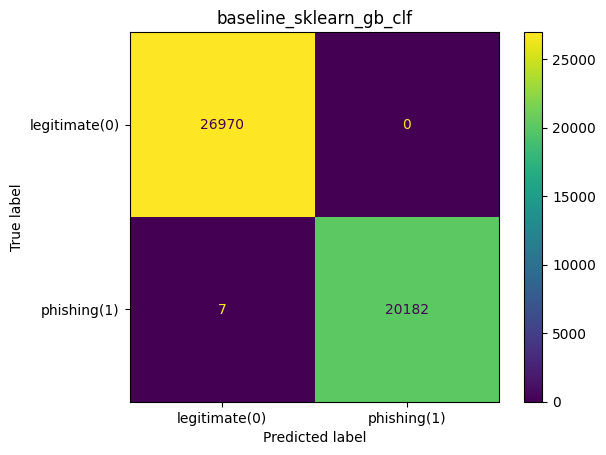

Fitting 2 folds for each of 216 candidates, totalling 432 fits

Best params (clf): {'l2_regularization': 0.0, 'learning_rate': 0.05, 'max_depth': 3, 'max_features': 0.5, 'max_iter': 50, 'min_samples_leaf': 20}

=== improved_sklearn_gb_clf ===
precision: 1.000000
recall:    1.000000
f1:        1.000000


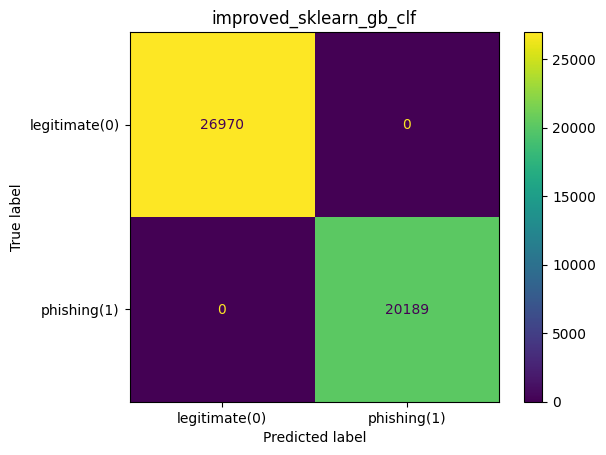


=== baseline_scratch_gb_clf ===
precision: 1.000000
recall:    0.999802
f1:        0.999901


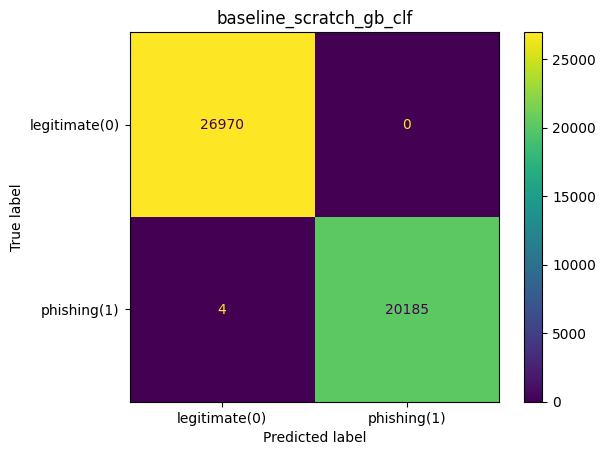


=== improved_scratch_gb_clf ===
precision: 1.000000
recall:    0.999802
f1:        0.999901


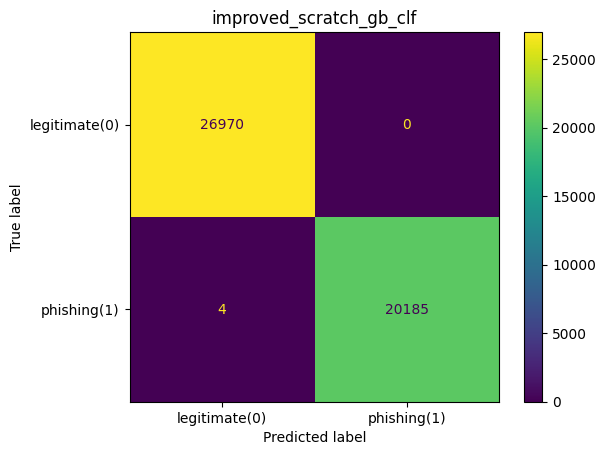


Classification comparison:


,precision,recall,f1
baseline_sklearn,1.0,0.999653,0.999827
improved_sklearn,1.0,1.000000,1.000000
baseline_scratch,1.0,0.999802,0.999901
improved_scratch,1.0,0.999802,0.999901


In [4]:
df_clf = load_from_kagglehub("ndarvind/phiusiil-phishing-url-dataset")

y_clf = (df_clf["label"] == 0).astype(int)
X_clf = df_clf.drop(columns=["label"])

text_cols_clf = [c for c in ["URL", "Domain", "TLD", "Title"] if c in X_clf.columns]
num_cols_clf = [c for c in X_clf.columns if c not in text_cols_clf]

X_train_clf_df, X_test_clf_df, y_train_clf, y_test_clf = train_test_split(
    X_clf[num_cols_clf], y_clf,
    test_size=TEST_SIZE,
    stratify=y_clf,
    random_state=RANDOM_STATE
)

imp_clf = SimpleImputer(strategy="median")
X_train_clf = imp_clf.fit_transform(X_train_clf_df).astype(np.float32)
X_test_clf = imp_clf.transform(X_test_clf_df).astype(np.float32)

gbc_base = HistGradientBoostingClassifier(
    loss="log_loss",
    learning_rate=0.1,
    max_depth=2,
    max_iter=50,
    min_samples_leaf=50,
    max_features=1.0,
    l2_regularization=0.0,
    max_bins=64,
    early_stopping=False,
    random_state=RANDOM_STATE
)
gbc_base.fit(X_train_clf, y_train_clf)
pred_base_clf = gbc_base.predict(X_test_clf)
baseline_sklearn_clf = eval_clf(y_test_clf, pred_base_clf, "baseline_sklearn_gb_clf")

# Гипотезы: подбор max_depth/max_iter/learning_rate/min_samples_leaf/max_features/l2_regularization по CV улучшит F1 за счёт баланса недо- и переобучения бустинга.
tune_n = min(TUNE_N_CLF, X_train_clf.shape[0])
X_tune_clf, _, y_tune_clf, _ = train_test_split(
    X_train_clf, y_train_clf,
    train_size=tune_n,
    stratify=y_train_clf,
    random_state=RANDOM_STATE
)

param_grid_clf = {
    "max_depth": [2, 3, 5],
    "max_iter": [50, 100],
    "learning_rate": [0.05, 0.1],
    "min_samples_leaf": [20, 50, 200],
    "max_features": [0.5, 1.0],
    "l2_regularization": [0.0, 0.1, 1.0],
}

cv_clf = StratifiedKFold(n_splits=CV_SPLITS_CLF, shuffle=True, random_state=RANDOM_STATE)

search_clf = GridSearchCV(
    HistGradientBoostingClassifier(
        loss="log_loss",
        max_bins=64,
        early_stopping=False,
        random_state=RANDOM_STATE
    ),
    param_grid=param_grid_clf,
    scoring="f1",
    refit=True,
    cv=cv_clf,
    n_jobs=-1,
    verbose=2
)
search_clf.fit(X_tune_clf, y_tune_clf)

best_params_clf = search_clf.best_params_
print("\nBest params (clf):", best_params_clf)

gbc_impr = search_clf.best_estimator_
gbc_impr.fit(X_train_clf, y_train_clf)
pred_impr_clf = gbc_impr.predict(X_test_clf)
improved_sklearn_clf = eval_clf(y_test_clf, pred_impr_clf, "improved_sklearn_gb_clf")

scratch_base_clf = HistGradientBoostingClassifierScratch(
    max_iter=int(gbc_base.max_iter),
    learning_rate=float(gbc_base.learning_rate),
    max_depth=None if gbc_base.max_depth is None else int(gbc_base.max_depth),
    min_samples_leaf=int(gbc_base.min_samples_leaf),
    max_features=float(gbc_base.max_features) if gbc_base.max_features is not None else 1.0,
    l2_regularization=float(gbc_base.l2_regularization),
    max_bins=int(gbc_base.max_bins),
    random_state=RANDOM_STATE
)
scratch_base_clf.fit(X_train_clf, np.asarray(y_train_clf, dtype=np.int32))
pred_s_base_clf = scratch_base_clf.predict(X_test_clf)
baseline_scratch_clf = eval_clf(y_test_clf, pred_s_base_clf, "baseline_scratch_gb_clf")

scratch_impr_clf = HistGradientBoostingClassifierScratch(
    max_iter=int(best_params_clf["max_iter"]),
    learning_rate=float(best_params_clf["learning_rate"]),
    max_depth=None if best_params_clf["max_depth"] is None else int(best_params_clf["max_depth"]),
    min_samples_leaf=int(best_params_clf["min_samples_leaf"]),
    max_features=float(best_params_clf["max_features"]),
    l2_regularization=float(best_params_clf["l2_regularization"]),
    max_bins=64,
    random_state=RANDOM_STATE
)
scratch_impr_clf.fit(X_train_clf, np.asarray(y_train_clf, dtype=np.int32))
pred_s_impr_clf = scratch_impr_clf.predict(X_test_clf)
improved_scratch_clf = eval_clf(y_test_clf, pred_s_impr_clf, "improved_scratch_gb_clf")

compare_clf = pd.DataFrame(
    [baseline_sklearn_clf, improved_sklearn_clf, baseline_scratch_clf, improved_scratch_clf],
    index=["baseline_sklearn", "improved_sklearn", "baseline_scratch", "improved_scratch"]
)
print("\nClassification comparison:")
display(compare_clf)

### Регрессия

In [8]:
df_reg_raw = load_from_kagglehub("anubhavgoyal10/laptop-prices-dataset")
df_reg = clean_laptop(df_reg_raw).dropna(subset=["Price"]).reset_index(drop=True)

y_reg = df_reg["Price"].astype(float)
X_reg = df_reg.drop(columns=["Price"])

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

num_cols_reg = [c for c in X_train_reg.columns if pd.api.types.is_numeric_dtype(X_train_reg[c])]
cat_cols_reg = [c for c in X_train_reg.columns if c not in num_cols_reg]

try:
    ohe_dense = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe_dense = OneHotEncoder(handle_unknown="ignore", sparse=False)

prep_reg = ColumnTransformer(
    transformers=[
        ("num", Pipeline([("imputer", SimpleImputer(strategy="median"))]), num_cols_reg),
        ("cat", Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("ohe", ohe_dense)]), cat_cols_reg),
    ],
    remainder="drop"
)

Xtr_reg_base = prep_reg.fit_transform(X_train_reg)
Xte_reg_base = prep_reg.transform(X_test_reg)

Xtr_reg_base = np.asarray(Xtr_reg_base, dtype=np.float32)
Xte_reg_base = np.asarray(Xte_reg_base, dtype=np.float32)

gbr_base = HistGradientBoostingRegressor(
    loss="squared_error",
    learning_rate=0.05,
    max_depth=2,
    max_iter=200,
    min_samples_leaf=20,
    max_features=1.0,
    l2_regularization=0.0,
    max_bins=64,
    early_stopping=False,
    random_state=RANDOM_STATE
)
gbr_base.fit(Xtr_reg_base, y_train_reg)
pred_base_reg = gbr_base.predict(Xte_reg_base)
baseline_sklearn_reg = eval_reg(y_test_reg, pred_base_reg, "baseline_sklearn_gb_reg")

# Гипотезы: подбор max_depth/max_iter/learning_rate/min_samples_leaf/l2_regularization/max_features по CV и использование log1p(Price) улучшит MAE/RMSE/R2.
param_grid_reg = {
    "reg__max_depth": [2, 3, 5],
    "reg__max_iter": [200, 400],
    "reg__learning_rate": [0.03, 0.05, 0.1],
    "reg__min_samples_leaf": [5, 10, 20, 50],
    "reg__l2_regularization": [0.0, 0.1, 1.0],
    "reg__max_features": [0.5, 1.0],
}

cv_reg = KFold(n_splits=CV_SPLITS_REG, shuffle=True, random_state=RANDOM_STATE)

pipe_plain = Pipeline([
    ("prep", prep_reg),
    ("reg", HistGradientBoostingRegressor(
        loss="squared_error",
        max_bins=64,
        early_stopping=False,
        random_state=RANDOM_STATE
    ))
])

search_plain = GridSearchCV(
    pipe_plain,
    param_grid=param_grid_reg,
    scoring="neg_mean_absolute_error",
    refit=True,
    cv=cv_reg,
    n_jobs=-1,
    verbose=2
)
search_plain.fit(X_train_reg, y_train_reg)

pipe_log = TransformedTargetRegressor(
    regressor=Pipeline([
        ("prep", prep_reg),
        ("reg", HistGradientBoostingRegressor(
            loss="squared_error",
            max_bins=64,
            early_stopping=False,
            random_state=RANDOM_STATE
        ))
    ]),
    func=np.log1p,
    inverse_func=np.expm1
)

param_grid_log = {f"regressor__{k}": v for k, v in param_grid_reg.items()}

search_log = GridSearchCV(
    pipe_log,
    param_grid=param_grid_log,
    scoring="neg_mean_absolute_error",
    refit=True,
    cv=cv_reg,
    n_jobs=-1,
    verbose=2
)
search_log.fit(X_train_reg, y_train_reg)

best_plain_score = float(search_plain.best_score_)
best_log_score = float(search_log.best_score_)

use_log = best_log_score > best_plain_score
best_model_reg = search_log.best_estimator_ if use_log else search_plain.best_estimator_

print("\nCV best (plain) MAE:", -best_plain_score)
print("CV best (log)   MAE:", -best_log_score)
print("Chosen improved model:", "log_target" if use_log else "plain_target")

pred_impr_reg = best_model_reg.predict(X_test_reg)
improved_sklearn_reg = eval_reg(y_test_reg, pred_impr_reg, "improved_sklearn_gb_reg")

if use_log:
    reg_step = best_model_reg.regressor_.named_steps["reg"]
    prep_final = best_model_reg.regressor_.named_steps["prep"]
    best_params_reg = {
        "max_depth": int(reg_step.max_depth),
        "max_iter": int(reg_step.max_iter),
        "learning_rate": float(reg_step.learning_rate),
        "min_samples_leaf": int(reg_step.min_samples_leaf),
        "max_features": float(reg_step.max_features) if reg_step.max_features is not None else 1.0,
        "l2_regularization": float(reg_step.l2_regularization),
        "log_target": True
    }
else:
    reg_step = best_model_reg.named_steps["reg"]
    prep_final = best_model_reg.named_steps["prep"]
    best_params_reg = {
        "max_depth": int(reg_step.max_depth),
        "max_iter": int(reg_step.max_iter),
        "learning_rate": float(reg_step.learning_rate),
        "min_samples_leaf": int(reg_step.min_samples_leaf),
        "max_features": float(reg_step.max_features) if reg_step.max_features is not None else 1.0,
        "l2_regularization": float(reg_step.l2_regularization),
        "log_target": False
    }

print("\nBest params (reg):", best_params_reg)

Xtr_reg_impr = prep_final.fit_transform(X_train_reg)
Xte_reg_impr = prep_final.transform(X_test_reg)
Xtr_reg_impr = np.asarray(Xtr_reg_impr, dtype=np.float32)
Xte_reg_impr = np.asarray(Xte_reg_impr, dtype=np.float32)

scratch_base_reg = HistGradientBoostingRegressorScratch(
    max_iter=int(gbr_base.max_iter),
    learning_rate=float(gbr_base.learning_rate),
    max_depth=None if gbr_base.max_depth is None else int(gbr_base.max_depth),
    min_samples_leaf=int(gbr_base.min_samples_leaf),
    max_features=float(gbr_base.max_features) if gbr_base.max_features is not None else 1.0,
    l2_regularization=float(gbr_base.l2_regularization),
    max_bins=int(gbr_base.max_bins),
    random_state=RANDOM_STATE
)
scratch_base_reg.fit(Xtr_reg_base, np.asarray(y_train_reg, dtype=np.float32))
pred_s_base_reg = scratch_base_reg.predict(Xte_reg_base)
baseline_scratch_reg = eval_reg(y_test_reg, pred_s_base_reg, "baseline_scratch_gb_reg")

scratch_impr_reg = HistGradientBoostingRegressorScratch(
    max_iter=int(best_params_reg["max_iter"]),
    learning_rate=float(best_params_reg["learning_rate"]),
    max_depth=None if best_params_reg["max_depth"] is None else int(best_params_reg["max_depth"]),
    min_samples_leaf=int(best_params_reg["min_samples_leaf"]),
    max_features=float(best_params_reg["max_features"]),
    l2_regularization=float(best_params_reg["l2_regularization"]),
    max_bins=64,
    random_state=RANDOM_STATE
)

if best_params_reg["log_target"]:
    y_train_used = np.log1p(np.asarray(y_train_reg, dtype=np.float32))
    scratch_impr_reg.fit(Xtr_reg_impr, y_train_used)
    pred_s_impr_reg = np.expm1(scratch_impr_reg.predict(Xte_reg_impr))
else:
    scratch_impr_reg.fit(Xtr_reg_impr, np.asarray(y_train_reg, dtype=np.float32))
    pred_s_impr_reg = scratch_impr_reg.predict(Xte_reg_impr)

improved_scratch_reg = eval_reg(y_test_reg, pred_s_impr_reg, "improved_scratch_gb_reg")

compare_reg = pd.DataFrame(
    [baseline_sklearn_reg, improved_sklearn_reg, baseline_scratch_reg, improved_scratch_reg],
    index=["baseline_sklearn", "improved_sklearn", "baseline_scratch", "improved_scratch"]
)
print("\nRegression comparison:")
display(compare_reg)


Loaded: anubhavgoyal10/laptop-prices-dataset
CSV: C:\Users\WARMACHINE\.cache\kagglehub\datasets\anubhavgoyal10\laptop-prices-dataset\versions\1\laptopPrice.csv
Shape: (823, 19)

=== baseline_sklearn_gb_reg ===
MAE:  15122.615
RMSE: 27258.640
R2:   0.61872
Fitting 5 folds for each of 432 candidates, totalling 2160 fits
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

CV best (plain) MAE: 11514.412628917602
CV best (log)   MAE: 10985.144115938256
Chosen improved model: log_target

=== improved_sklearn_gb_reg ===
MAE:  12425.463
RMSE: 24622.373
R2:   0.68891

Best params (reg): {'max_depth': 5, 'max_iter': 400, 'learning_rate': 0.05, 'min_samples_leaf': 10, 'max_features': 0.5, 'l2_regularization': 0.0, 'log_target': True}

=== baseline_scratch_gb_reg ===
MAE:  15207.199
RMSE: 28541.097
R2:   0.58200

=== improved_scratch_gb_reg ===
MAE:  12851.252
RMSE: 26380.407
R2:   0.64290

Regression comparison:


,MAE,RMSE,R2
baseline_sklearn,15122.615153,27258.639716,0.618724
improved_sklearn,12425.463230,24622.372775,0.688906
baseline_scratch,15207.199432,28541.097112,0.582004
improved_scratch,12851.251965,26380.407162,0.642896


# Итоговое сравнение результатов ЛР1–ЛР5

Ниже сведены результаты всех лабораторных для двух задач: классификация (PhiUSIIL Phishing URL Dataset) и регрессия (Laptop Prices Dataset). Для классификации использовались метрики *precision/recall/F1* (позитивный класс - phishing), для регрессии - *MAE/RMSE/R²*.

## Классификация (PhiUSIIL)

| ЛР / алгоритм | baseline (sklearn) F1 | improved (sklearn) F1 | baseline (scratch) F1 | improved (scratch) F1 |
|---|---:|---:|---:|---:|
| ЛР1 - KNN | 0.997296 | 0.998761 | 0.997296 | 0.998761 |
| ЛР2 - Logistic Regression | 0.999703 | 0.999926 | 0.689704 | 0.996705 |
| ЛР3 - Decision Tree | 0.999827 | 1.000000 | 0.999901 | 0.999901 |
| ЛР4 - Random Forest | 0.999950 | 0.999950 | 0.999926 | 0.999950 |
| ЛР5 - Gradient Boosting | 0.999827 | 1.000000 | 0.999901 | 0.999901 |

В ходе работ по классификации на PhiUSIIL для библиотечных моделей (sklearn) почти во всех лабораторных получены значения F1 ≈ 1.0: в ЛР3 и ЛР5 improved дал F1=1.000000, в ЛР4 baseline и improved совпали (F1=0.999950). KNN (ЛР1) показал более низкие значения: F1 вырос с 0.997296 до 0.998761, но остался ниже результатов деревьев и ансамблей. По scratch-реализациям наблюдается, что в ЛР1 метрики полностью совпали с sklearn, в ЛР2 baseline scratch существенно уступил sklearn (F1=0.689704), а после улучшений достиг F1=0.996705. В ЛР3 и ЛР5 для scratch улучшение не привело к изменению метрик (baseline = improved).

## Регрессия (Laptop Prices)

| ЛР / алгоритм | baseline (sklearn) MAE / RMSE / R² | improved (sklearn) MAE / RMSE / R² | baseline (scratch) MAE / RMSE / R² | improved (scratch) MAE / RMSE / R² |
|---|---|---|---|---|
| ЛР1 - KNN reg | 22184.656 / 34194.148 / 0.400023 | 13450.772 / 25372.392 / 0.669665 | 22280.132 / 34301.199 / 0.396260 | 13268.366 / 25201.392 / 0.674103 |
| ЛР2 - Linear / Ridge (+log target) | 15633.242 / 24887.438 / 0.682172 | 13470.549 / 23615.297 / 0.713834 | 15633.242 / 24887.438 / 0.682172 | 13470.549 / 23615.297 / 0.713834 |
| ЛР3 - Decision Tree reg | 22153.337 / 35366.915 / 0.358162 | 15326.030 / 28791.405 / 0.574640 | 22789.641 / 36960.390 / 0.299022 | 15676.690 / 28848.885 / 0.572940 |
| ЛР4 - Random Forest reg | 12659.241 / 23387.433 / 0.719330 | 11712.505 / 22645.432 / 0.736857 | 12683.220 / 23817.251 / 0.708919 | 12232.931 / 23639.430 / 0.713249 |
| ЛР5 - Gradient Boosting reg (+log target) | 15122.615 / 27258.640 / 0.618724 | 12425.463 / 24622.373 / 0.688906 | 15207.199 / 28541.097 / 0.582004 | 12851.252 / 26380.407 / 0.642896 |

В ходе работ по регрессии лучший результат по sklearn показал случайный лес (ЛР4 improved): MAE=11712.505, RMSE=22645.432, R²=0.736857. Ридж-регрессия из ЛР2 (improved) дала близкие значения (R²=0.713834), при этом метрики scratch полностью совпали с sklearn. KNN-регрессия (ЛР1) существенно улучшилась относительно бейзлайна (R²: 0.400023 → 0.669665), но итоговое качество осталось ниже, чем у ЛР2 и ЛР4. Решающее дерево (ЛР3) после подбора гиперпараметров улучшилось до R²=0.574640, но уступило ансамблевым методам. Градиентный бустинг (ЛР5 improved) улучшился до R²=0.688906, однако не превзошёл случайный лес и ридж по итоговым метрикам.

## Общий итог

В ходе выполнения лабораторных работ на задаче классификации (PhiUSIIL) все библиотечные модели, начиная уже со 2–3 лабораторной, вышли на значения *precision/recall/F1*, близкие к 1.0. Это означает, что на выбранном наборе признаков модель практически без ошибок отделяет phishing от legitimate. На этом фоне улучшения (тюнинг параметров) часто дают минимальный прирост или вовсе не меняют результат, потому что качество уже находится около потолка метрик. KNN в ЛР1 показал заметно более низкие значения F1 по сравнению с деревьями и ансамблями (даже после улучшений), то есть при тех же данных он разделяет классы хуже, чем логистическая регрессия/деревья/ансамбли.  
Отдельно по собственным реализациям: в ряде лабораторных наблюдалось совпадение или близость к sklearn (например, в ЛР1, ЛР3, ЛР4), но в ЛР2 baseline scratch существенно отставал от sklearn и только после улучшений приблизился к библиотечной модели. Это показывает, что при реализации с нуля чувствительными оказываются детали обучения/оптимизации и корректная настройка улучшений.

В ходе выполнения лабораторных работ на задаче регрессии (Laptop Prices) различия между алгоритмами выражены сильнее: метрики *MAE/RMSE/R²* заметно меняются от модели к модели. По итоговым значениям лучший результат среди sklearn дал случайный лес (ЛР4 improved) (минимальный MAE и максимальный R² среди всех приведённых результатов), затем близко подошла ридж-регрессия с преобразованием цели (ЛР2 improved). При этом KNN-регрессия (ЛР1) показала очень сильное улучшение относительно своего бейзлайна (R² вырос примерно с 0.40 до ~0.67), но по итоговому качеству всё равно уступила ЛР2 и ЛР4. Решающее дерево (ЛР3) улучшилось после подбора параметров, однако осталось слабее ансамблевых методов. Градиентный бустинг (ЛР5 improved) тоже улучшился, но в этих запусках не превзошёл случайный лес и ридж по итоговым метрикам.

Итого по двум задачам: на классификации большинство “сильных” моделей быстро упираются в почти идеальные метрики на данном наборе признаков, поэтому различия между ними становятся малозаметными; на регрессии качество сильнее зависит от выбранного алгоритма и настройки, и по представленным результатам лучше всего себя показали ансамбли деревьев (особенно случайный лес) и регуляризованная линейная модель (ridge) с преобразованием целевой переменной.